In [6]:
%pip install imbalanced-learn
%pip install matplotlib
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 KB 1.0 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 2.4 MB/s eta 0:00:0000:0100:01m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 505.5/505.5 KB 3.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.4/345.4 KB 2.3 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [3]:
import tensorflow as tf
from tensorflow.keras import models, layers, regularizers
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE

2024-08-12 15:17:11.946010: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-12 15:17:11.965912: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-12 15:17:12.054321: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-12 15:17:12.054403: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-12 15:17:12.070155: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

In [4]:


print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  0


2024-08-12 15:17:14.671339: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-12 15:17:14.687022: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [5]:
IMAGE_SIZE = 256
CHANNELS = 3
BATCH_SIZE = 16
EPOCHS = 20

In [6]:
# Load dataset
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/home/dell/Desktop/chest_xray",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

class_names = dataset.class_names

Found 5856 files belonging to 3 classes.


In [ ]:
# data_augmentation = tf.keras.Sequential([
#     layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
#     layers.experimental.preprocessing.RandomRotation(0.2),
#     layers.experimental.preprocessing.RandomZoom(0.2),
# ])

# train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

In [8]:
# Prepare data for SMOTE
def flatten_images(images, labels):
    images = tf.reshape(images, (-1, IMAGE_SIZE * IMAGE_SIZE * CHANNELS))
    return images.numpy(), labels.numpy()

X, y = [], []
for images, labels in dataset:
    X_batch, y_batch = flatten_images(images, labels)
    X.append(X_batch)
    y.append(y_batch)

X = np.concatenate(X)
y = np.concatenate(y)

In [10]:
# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [11]:

# Split data into training, validation, and test sets before applying SMOTE
X_train, X_temp, y_train, y_temp = train_test_split(X, y_encoded, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [12]:
# Apply SMOTE
smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X, y_encoded)

In [13]:
# Reshape the resampled data back to the original image shape
X_resampled = np.reshape(X_resampled, (-1, IMAGE_SIZE, IMAGE_SIZE, CHANNELS))

In [14]:
# Convert the resampled data back to TensorFlow datasets
def create_tf_dataset(images, labels, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))
    dataset = dataset.shuffle(1000).batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

resampled_dataset = create_tf_dataset(X_resampled, y_resampled, BATCH_SIZE)

# Split dataset into train, validation, and test sets with at least 10% for validation and testing
dataset_size = len(y_resampled)
train_size = int(0.7 * dataset_size)
val_size = max(1, int(0.15 * dataset_size))  # Ensuring at least one batch for validation
test_size = max(1, dataset_size - train_size - val_size)  # Ensuring at least one batch for testing

train_ds = resampled_dataset.take(train_size)
remaining_ds = resampled_dataset.skip(train_size)
val_ds = remaining_ds.take(val_size)
test_ds = remaining_ds.skip(val_size)

In [15]:
# Verify that the datasets are not empty
print(f"Train set size: {len(list(train_ds))}")
print(f"Validation set size: {len(list(val_ds))}")
print(f"Test set size: {len(list(test_ds))}")

Train set size: 522
Validation set size: 0
Test set size: 0


: 

In [33]:
# Define the CNN model with regularization
model = models.Sequential([
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS), kernel_regularizer=regularizers.l2(0.001)),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),  # Dropout to prevent overfitting
    
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    
    layers.Conv2D(128, kernel_size=(3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    
    layers.Flatten(),
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.5),  # Increased dropout for the fully connected layer
    
    layers.Dense(len(class_names), activation='softmax'),
])

In [5]:
# # Prepare data for SMOTE by flattening images to 1D
# def flatten_images(images, labels):
#     images = tf.reshape(images, (-1, IMAGE_SIZE * IMAGE_SIZE * CHANNELS))
#     return images.numpy(), labels.numpy()

# X, y = [], []
# for images, labels in dataset:
#     X_batch, y_batch = flatten_images(images, labels)
#     X.append(X_batch)
#     y.append(y_batch)

# X = np.concatenate(X)
# y = np.concatenate(y)


In [6]:
# # Apply SMOTE to balance the dataset
# smote = SMOTE()
# X_resampled, y_resampled = smote.fit_resample(X, y)

In [7]:
# # Reshape the resampled data back to the original image shape
# X_resampled = np.reshape(X_resampled, (-1, IMAGE_SIZE, IMAGE_SIZE, CHANNELS))


In [8]:
# # Convert the resampled data back to TensorFlow datasets
# resampled_dataset = tf.data.Dataset.from_tensor_slices((X_resampled, y_resampled))

In [9]:
# # Split dataset into train, validation, and test sets
# train_size = int(0.7 * len(resampled_dataset))
# val_size = int(0.15 * len(resampled_dataset))
# test_size = len(resampled_dataset) - train_size - val_size

# train_ds = resampled_dataset.take(train_size)
# val_ds = resampled_dataset.skip(train_size).take(val_size)
# test_ds = resampled_dataset.skip(train_size + val_size)

# train_ds = train_ds.cache().shuffle(1000).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
# val_ds = val_ds.cache().shuffle(1000).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
# test_ds = test_ds.cache().shuffle(1000).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

In [10]:
# print("shape of X_sampled before shaping", X_resampled.shape)

shape of X_sampled before shaping (8340, 256, 256, 3)


In [11]:
# model = models.Sequential([
#     layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS), 
#  kernel_regularizer=regularizers.l2(l2_weight=0.001)),
#     layers.MaxPooling2D((2, 2)),
#     layers.Conv2D(64, kernel_size=(3, 3), activation='relu', kernel_regularizer=regularizers.l2(l2_weight=0.001)),
#     layers.MaxPooling2D((2, 2)),
#     layers.Conv2D(128, kernel_size=(3, 3), activation='relu', kernel_regularizer=regularizers.l2(l2_weight=0.001)),
#     layers.MaxPooling2D((2, 2)),
#     layers.Dropout(0.2),  # Add Dropout after convolutional layers
#     layers.Flatten(),
#     layers.Dense(64, activation='relu'),
#     layers.Dropout(0.3),  # Add Dropout after dense layer
#     layers.Dense(n_classes, activation='softmax'),
# ])

In [34]:
# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)


In [35]:
# Train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    verbose=1
)

Epoch 1/50
522/522 [==============================] - ETA: 0s - loss: 5.1402 - accuracy: 0.3564

ValueError: Expected input data to be non-empty.

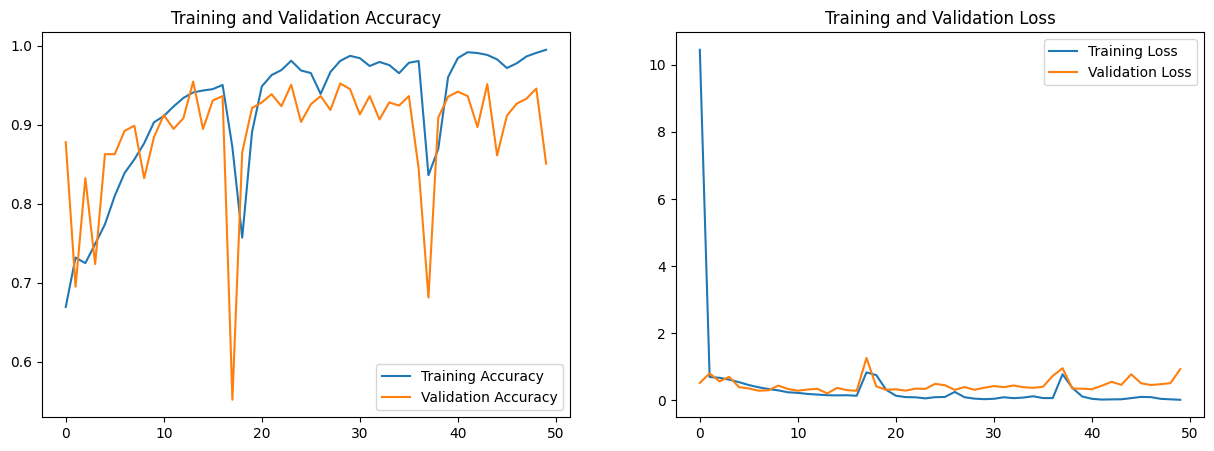

In [14]:
# Plot training and validation accuracy and loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

1/1 [==============================] - 0s 19ms/step


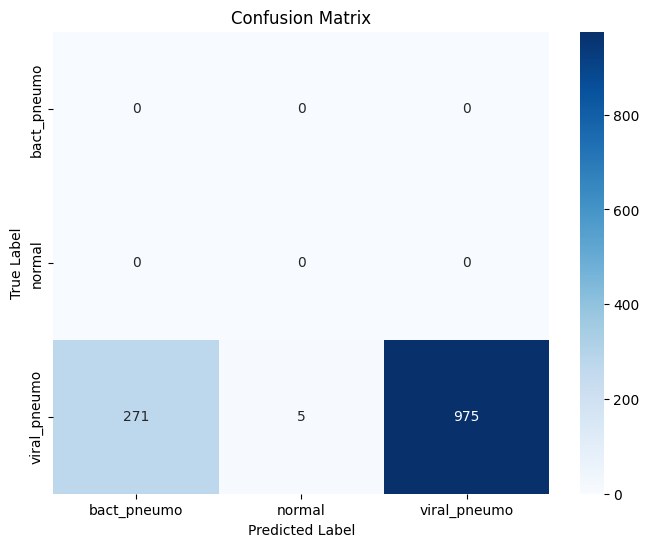

Classification Report:
               precision    recall  f1-score   support

 bact_pneumo       0.00      0.00      0.00         0
      normal       0.00      0.00      0.00         0
viral_pneumo       1.00      0.78      0.88      1251

    accuracy                           0.78      1251
   macro avg       0.33      0.26      0.29      1251
weighted avg       1.00      0.78      0.88      1251



/home/dell/CNN/py_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/dell/CNN/py_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/dell/CNN/py_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [15]:
# Evaluate the model on the test set
true_labels = []
pred_labels = []

for images, labels in test_ds:
    preds = model.predict(images)
    pred_labels.extend(np.argmax(preds, axis=1))
    true_labels.extend(labels.numpy())

true_labels = np.array(true_labels)
pred_labels = np.array(pred_labels)

# Generate and plot the confusion matrix
conf_matrix = confusion_matrix(true_labels, pred_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Generate the classification report
report = classification_report(true_labels, pred_labels, target_names=class_names)
print("Classification Report:\n", report)